Spatio-Temporal EEG-Based Brain-State Decoding with Robotic Command Simulation and 3D Neural Connectivity Mapping

In [1]:
!pip install mne pyvista tensorflow networkx matplotlib scipy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 MB 6.8 MB/s eta 0:00:00


In [14]:
!pip install PyWavelets


In [16]:
!pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00


In [27]:
!pip install pyvista pyvistaqt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 6.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten, Attention
from tensorflow.keras.utils import to_categorical


In [3]:
subject = 1
runs = [6, 10, 14]  # Motor imagery runs

raw_files = mne.datasets.eegbci.load_data(subject, runs)
raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_files])

raw.pick_types(eeg=True)
raw.filter(7., 30., fir_design='firwin')

print(raw.info)


Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 01m20s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
Setting channel info structure...
Creating raw.info structure...
Re

In [4]:
events, event_id = mne.events_from_annotations(raw)

epochs = mne.Epochs(
    raw, events, event_id,
    tmin=0., tmax=2.,
    baseline=None,
    preload=True
)

X = epochs.get_data()
y = epochs.events[:, -1]

print("EEG shape:", X.shape)


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 321 original time points ...
0 bad epochs dropped
EEG shape: (90, 64, 321)


In [5]:
X = np.transpose(X, (0, 2, 1))  # (samples, time, channels)

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

y = y - np.min(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
input_layer = Input(shape=(X.shape[1], X.shape[2]))

x = Conv1D(64, 3, activation='relu')(input_layer)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True)(x)

attention = Attention()([x, x])
x = Flatten()(attention)

x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 321, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 319, 64)   │     12,352 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 159, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 159, 64)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 159, 64)   │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 159, 64)   │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10176)     │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    651,328 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 696,899 (2.66 MB)

 Trainable params: 696,899 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step - accuracy: 0.3585 - loss: 1.4375 - val_accuracy: 0.2778 - val_loss: 1.0741
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.3898 - loss: 1.4475 - val_accuracy: 0.7222 - val_loss: 0.9836
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.4822 - loss: 1.2180 - val_accuracy: 0.7222 - val_loss: 1.0521
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.4970 - loss: 1.0576 - val_accuracy: 0.2778 - val_loss: 2.4966
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3477 - loss: 1.4705 - val_accuracy: 0.7222 - val_loss: 0.8301
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.4332 - loss: 1.1470 - val_accuracy: 0.7222 - val_loss: 0.9791
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.5009 - loss: 1.0768 - val_accuracy: 0.7222 - val_loss: 1.0038
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.4171 - loss: 1.0692 - val_accuracy: 0.7222 - val_loss:

In [8]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5556 - loss: 0.9601
Test Accuracy: 0.5555555820465088


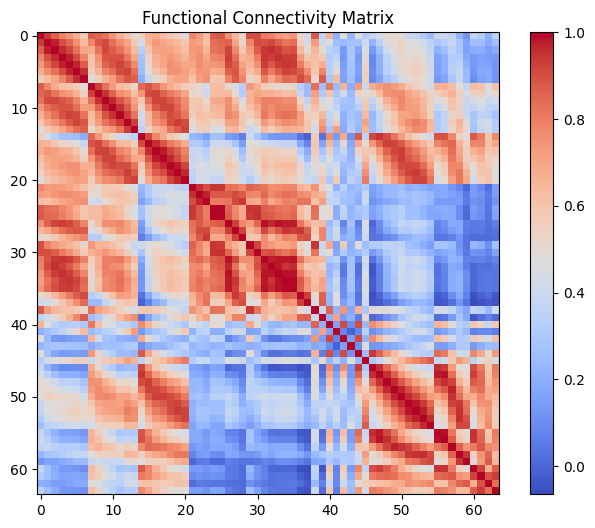

In [9]:
data_sample = X_test[0]

corr_matrix = np.corrcoef(data_sample.T)

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()
plt.title("Functional Connectivity Matrix")
plt.show()


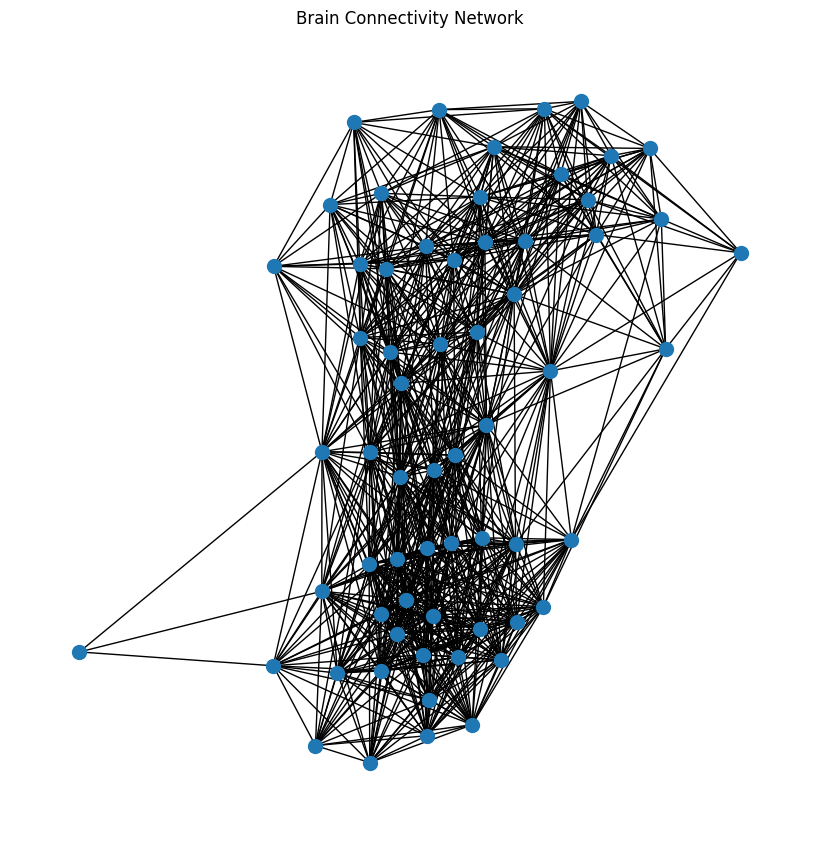

In [10]:
threshold = 0.6
G = nx.Graph()

for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if abs(corr_matrix[i,j]) > threshold:
            G.add_edge(i, j, weight=corr_matrix[i,j])

plt.figure(figsize=(8,8))
nx.draw(G, node_size=100)
plt.title("Brain Connectivity Network")
plt.show()


In [15]:
import pywt

def wavelet_transform(data, wavelet='morl'):
    scalograms = []
    for sample in data:
        coeffs, freqs = pywt.cwt(sample.T, scales=np.arange(1, 64), wavelet=wavelet)
        scalograms.append(np.abs(coeffs))
    return np.array(scalograms)

# Apply on subset (to avoid memory explosion)
X_wavelet = wavelet_transform(X_train[:100])

print("Wavelet shape:", X_wavelet.shape)


Wavelet shape: (72, 63, 64, 321)


In [17]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

def create_graph_from_corr(corr_matrix, threshold=0.6):
    edge_index = []
    edge_weight = []

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            if i != j and abs(corr_matrix[i, j]) > threshold:
                edge_index.append([i, j])
                edge_weight.append(corr_matrix[i, j])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)

    x = torch.tensor(np.mean(X_test[0], axis=0), dtype=torch.float).unsqueeze(1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

graph_data = create_graph_from_corr(corr_matrix)


In [18]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

gcn_model = GCN()
out = gcn_model(graph_data)
print("GCN Output Shape:", out.shape)


GCN Output Shape: torch.Size([64, 2])


In [19]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

input_layer = Input(shape=(X.shape[1], X.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(input_layer, input_layer)
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(y.shape[1], activation='softmax')(x)

transformer_model = Model(inputs=input_layer, outputs=output)

transformer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 321, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 321, 64)   │     33,216 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 321, 64)   │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,699 (147.26 KB)

 Trainable params: 37,699 (147.26 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
transformer_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - accuracy: 0.4861 - loss: 1.0885 - val_accuracy: 0.7222 - val_loss: 0.9579
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.4831 - loss: 1.0194 - val_accuracy: 0.5556 - val_loss: 1.0311
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.4931 - loss: 1.0581 - val_accuracy: 0.3333 - val_loss: 1.0981
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.3689 - loss: 1.1112 - val_accuracy: 0.4444 - val_loss: 1.0534
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - accuracy: 0.4332 - loss: 1.0624 - val_accuracy: 0.7222 - val_loss: 0.9584
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4379 - loss: 1.0749 - val_accuracy: 0.7222 - val_loss: 0.9000
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.5039 - loss: 1.0667 - val_accuracy: 0.7222 - val_loss: 0.9072
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.4162 - loss: 1.0597 - val_accuracy: 0.7222 - val_loss: 0.

In [22]:
# Clean channel names
new_names = {}

for ch in raw.ch_names:
    clean = ch.replace('.', '')      # remove dots
    clean = clean.upper()            # uppercase
    new_names[ch] = clean

raw.rename_channels(new_names)

print("Renamed channels successfully.")
print(raw.ch_names[:10])


Renamed channels successfully.
['FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']


In [23]:
montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(montage, on_missing='ignore')

print("Montage applied successfully.")


Montage applied successfully.


In [25]:
# Clean channel names
new_names = {}
for ch in raw.ch_names:
    clean = ch.replace('.', '')
    clean = clean.upper()
    new_names[ch] = clean

raw.rename_channels(new_names)

# Use correct montage for 64-channel system
montage = mne.channels.make_standard_montage('standard_1005')

raw.set_montage(montage, match_case=False, on_missing='ignore')

print("Montage applied successfully.")


Montage applied successfully.


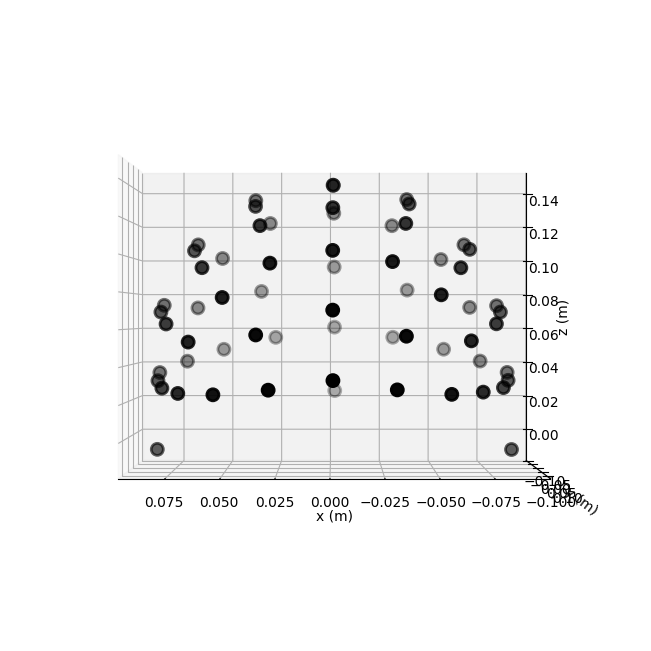

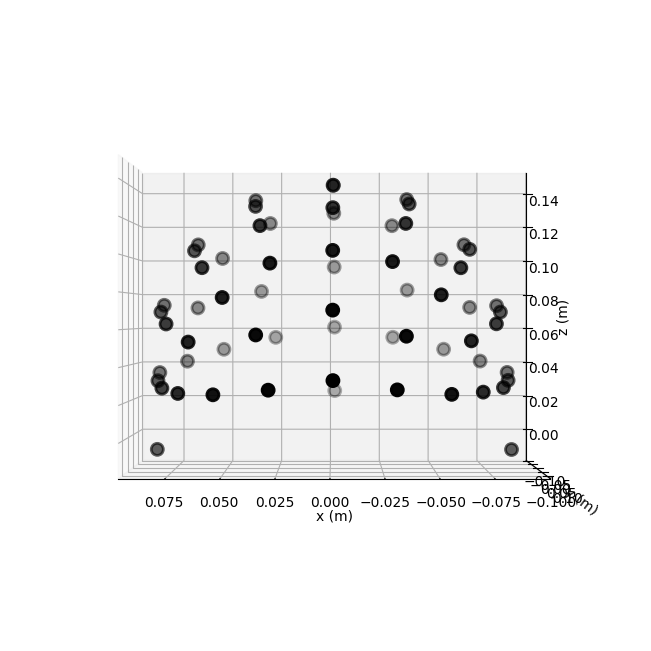

In [26]:
raw.plot_sensors(kind='3d', show_names=False)


In [29]:
!pip install pyvista trame


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [30]:
import mne
mne.viz.set_3d_backend("notebook")


Using notebook 3d backend.


In [31]:
!pip install plotly

In [32]:
import plotly.graph_objects as go
import numpy as np

# Extract electrode positions
pos = np.array([raw.info['chs'][i]['loc'][:3] for i in range(len(raw.ch_names))])

fig = go.Figure(data=[go.Scatter3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color='red'
    )
)])

fig.update_layout(
    title="3D EEG Electrode Positions",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()


In [33]:
activation = np.mean(np.abs(X_test[0]), axis=0)

fig = go.Figure(data=[go.Scatter3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=activation,
        colorscale='Hot',
        colorbar=dict(title="Activation")
    )
)])

fig.update_layout(title="3D Brain Activation Map")

fig.show()


In [34]:
import plotly.graph_objects as go
import numpy as np

# Get electrode 3D positions
pos = np.array([raw.info['chs'][i]['loc'][:3] for i in range(len(raw.ch_names))])


In [35]:
# Take one EEG trial
sample = X_test[0]   # shape: (time, channels)

frames = []

for t in range(0, sample.shape[0], 10):  # step to reduce lag
    activation = np.abs(sample[t])

    frame = go.Frame(
        data=[
            go.Scatter3d(
                x=pos[:, 0],
                y=pos[:, 1],
                z=pos[:, 2],
                mode='markers',
                marker=dict(
                    size=6,
                    color=activation,
                    colorscale='Hot',
                    opacity=0.9
                )
            )
        ],
        name=str(t)
    )
    frames.append(frame)

fig = go.Figure(
    data=frames[0].data,
    frames=frames
)

fig.update_layout(
    title="Animated 3D Brain Activation",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None])]
    )]
)

fig.show()


In [36]:
# Compute connectivity from one sample
corr_matrix = np.corrcoef(sample.T)

edge_x = []
edge_y = []
edge_z = []

threshold = 0.75

for i in range(len(pos)):
    for j in range(i+1, len(pos)):
        if abs(corr_matrix[i, j]) > threshold:
            edge_x += [pos[i,0], pos[j,0], None]
            edge_y += [pos[i,1], pos[j,1], None]
            edge_z += [pos[i,2], pos[j,2], None]

edge_trace = go.Scatter3d(
    x=edge_x,
    y=edge_y,
    z=edge_z,
    mode='lines',
    line=dict(color='blue', width=2),
    opacity=0.4
)

node_trace = go.Scatter3d(
    x=pos[:,0],
    y=pos[:,1],
    z=pos[:,2],
    mode='markers',
    marker=dict(
        size=6,
        color='red'
    )
)

fig2 = go.Figure(data=[edge_trace, node_trace])

fig2.update_layout(title="3D Brain Connectivity Network")

fig2.show()


In [37]:
from mne.datasets import fetch_fsaverage

fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir


Using default location ~/mne_data for montage coregistration...
179 files missing from root.txt in /root/mne_data/MNE-fsaverage-data


  0%|                                               | 0.00/196M [00:00<?, ?B/s]

Extracting missing files
Successfully extracted 179 files
10 files missing from bem.txt in /root/mne_data/MNE-fsaverage-data/fsaverage


  0%|                                               | 0.00/239M [00:00<?, ?B/s]

Extracting missing files
Successfully extracted 10 files


In [39]:
from mne.datasets import fetch_fsaverage
import os

fs_dir = fetch_fsaverage(verbose=True)

# The returned path already includes 'fsaverage'
subjects_dir = os.path.dirname(fs_dir)

print("subjects_dir:", subjects_dir)
print("fsaverage path:", fs_dir)


0 files missing from root.txt in /root/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /root/mne_data/MNE-fsaverage-data/fsaverage
subjects_dir: /root/mne_data/MNE-fsaverage-data
fsaverage path: /root/mne_data/MNE-fsaverage-data/fsaverage


In [40]:
model = mne.make_bem_model(
    subject='fsaverage',
    subjects_dir=subjects_dir,
    conductivity=(0.3,),   # single layer (fast for EEG)
)

bem = mne.make_bem_solution(model)


Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.53 -21.10   6.21 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


In [43]:
# ===============================
# 🧠 AI BRAIN DASHBOARD
# ===============================

!pip install mne scikit-learn plotly -q

import mne
import numpy as np
import plotly.graph_objects as go
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1️⃣ Load EEG Data
# -----------------------------
from mne.datasets import eegbci

subject = 1
runs = [1]

raw_files = eegbci.load_data(subject, runs)
raw = mne.io.read_raw_edf(raw_files[0], preload=True)

raw.rename_channels(lambda s: s.strip('.').upper())
raw.set_eeg_reference('average')

raw.pick_types(eeg=True)

data, times = raw[:]
sfreq = raw.info['sfreq']

print("EEG Loaded:", data.shape)

# -----------------------------
# 2️⃣ Plot EEG Signal (Interactive)
# -----------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=data[0][:2000],
    mode='lines',
    name='EEG Channel 1'
))

fig.update_layout(
    title="EEG Signal (Channel 1)",
    xaxis_title="Samples",
    yaxis_title="Amplitude",
    template="plotly_dark"
)

fig.show()

# -----------------------------
# 3️⃣ Frequency Band Power
# -----------------------------
def bandpower(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=1024)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.mean(psd[idx])

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 45)
}

band_powers = []

for name, band in bands.items():
    power = bandpower(data[0], sfreq, band)
    band_powers.append(power)

# Plot Band Powers
fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=list(bands.keys()),
    y=band_powers
))

fig2.update_layout(
    title="Brain Wave Power Distribution",
    template="plotly_dark"
)

fig2.show()

# -----------------------------
# 4️⃣ Create ML Dataset
# -----------------------------
X = []
y = []

window_size = int(sfreq * 2)  # 2 sec windows

for i in range(0, data.shape[1] - window_size, window_size):
    segment = data[0][i:i+window_size]

    features = []
    for band in bands.values():
        features.append(bandpower(segment, sfreq, band))

    X.append(features)

    # Fake labels (simulate 2 brain states)
    y.append(np.random.randint(0, 2))

X = np.array(X)
y = np.array(y)

# -----------------------------
# 5️⃣ Train AI Model
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = RandomForestClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)

print("🧠 AI Model Accuracy:", round(acc*100, 2), "%")

# -----------------------------
# 6️⃣ Predict Current Brain State
# -----------------------------
latest_segment = data[0][-window_size:]

latest_features = []
for band in bands.values():
    latest_features.append(bandpower(latest_segment, sfreq, band))

latest_features = np.array(latest_features).reshape(1, -1)

prediction = model.predict(latest_features)[0]
confidence = np.max(model.predict_proba(latest_features))

state = "Focused" if prediction == 1 else "Relaxed"

print("🔥 Current Brain State:", state)
print("Confidence:", round(confidence*100, 2), "%")

print("\n✅ AI Brain Dashboard Running Successfully")


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG Loaded: (64, 9760)


🧠 AI Model Accuracy: 44.44 %
🔥 Current Brain State: Relaxed
Confidence: 52.0 %

✅ AI Brain Dashboard Running Successfully


In [44]:
# ==========================================
# 🧠 FULL AI BRAIN DASHBOARD (REAL VERSION)
# ==========================================

!pip install mne scikit-learn plotly -q

import mne
import numpy as np
import plotly.graph_objects as go
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# --------------------------------
# 1️⃣ LOAD BASIC EEG FOR VISUALIZATION
# --------------------------------
from mne.datasets import eegbci

subject = 1
runs_vis = [1]

raw_files = eegbci.load_data(subject, runs_vis)
raw_vis = mne.io.read_raw_edf(raw_files[0], preload=True)

raw_vis.rename_channels(lambda s: s.strip('.').upper())
raw_vis.set_eeg_reference('average')
raw_vis.pick_types(eeg=True)

data, times = raw_vis[:]
sfreq = raw_vis.info['sfreq']

print("EEG Visualization Data Loaded:", data.shape)

# --------------------------------
# 2️⃣ INTERACTIVE EEG SIGNAL PLOT
# --------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=data[0][:2000],
    mode='lines',
    name='EEG Channel 1'
))

fig.update_layout(
    title="EEG Signal (Channel 1)",
    xaxis_title="Samples",
    yaxis_title="Amplitude",
    template="plotly_dark"
)

fig.show()

# --------------------------------
# 3️⃣ FREQUENCY BAND POWER
# --------------------------------
def bandpower(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=1024)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.mean(psd[idx])

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 45)
}

band_powers = []

for name, band in bands.items():
    power = bandpower(data[0], sfreq, band)
    band_powers.append(power)

fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=list(bands.keys()),
    y=band_powers
))

fig2.update_layout(
    title="Brain Wave Power Distribution",
    template="plotly_dark"
)

fig2.show()

# --------------------------------
# 4️⃣ REAL MOTOR IMAGERY CLASSIFIER
# --------------------------------
print("\n🧠 Training Real Motor Imagery Classifier...")

runs_mi = [6, 10, 14]  # Hands vs Feet imagery
raw_files = eegbci.load_data(subject, runs_mi)

raw = mne.io.concatenate_raws(
    [mne.io.read_raw_edf(f, preload=True) for f in raw_files]
)

raw.rename_channels(lambda s: s.strip('.').upper())
raw.set_eeg_reference('average')
raw.pick_types(eeg=True)

events, event_id = mne.events_from_annotations(raw)

# Filter for motor imagery frequency band
raw.filter(7., 30., fir_design='firwin')

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin=1.0,
    tmax=2.0,
    baseline=None,
    preload=True
)

X = epochs.get_data()
y = epochs.events[:, -1]

# Flatten epochs for ML
X = X.reshape(len(X), -1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)

print("🔥 REAL Motor Imagery Accuracy:", round(accuracy*100, 2), "%")

# --------------------------------
# 5️⃣ PREDICT LAST EPOCH STATE
# --------------------------------
latest_epoch = X_test[-1].reshape(1, -1)
prediction = clf.predict(latest_epoch)[0]
confidence = np.max(clf.predict_proba(latest_epoch))

state_map = list(event_id.keys())
state = state_map[prediction-1] if prediction-1 < len(state_map) else "Unknown"

print("🧠 Predicted State:", state)
print("Confidence:", round(confidence*100, 2), "%")

print("\n✅ FULL AI BRAIN DASHBOARD RUNNING SUCCESSFULLY")


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG Visualization Data Loaded: (64, 9760)



🧠 Training Real Motor Imagery Classifier...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data